# Verify Climatology
In this notebook plot base zonal avg plots of potential temperature and zonal wind to check the characteristic of the control runs and the pertubations are inline with what is expected for the given launch configuration.  

### Load Deps

In [2]:
!module load ffmpeg
import os 
import re 
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from glob import glob 
plt.rcParams['animation.ffmpeg_path'] ='/share/software/user/open/ffmpeg/5.0/bin/ffmpeg'

Specify target files

In [4]:
def load_am4(month='jan'):
    BASE_DIR = os.path.join('/scratch/users/robcking/am4_error_growth_full',month)

    #LOAD PERTURBED ENSEMBLES
    perturbed_memberlist = sorted(filter(lambda x: re.match(r'.+\/[0-9]+\/atmos_4xdaily.nc',x),glob(os.path.join(BASE_DIR,'*','atmos_4xdaily.nc'))),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
    perturbed_ds =  xr.open_mfdataset(perturbed_memberlist,combine='nested',concat_dim='members',chunks={'pfull':11,'lat':50})

    #LOAD CTL PATH
    ctl_path = os.path.join(BASE_DIR,'ctl','atmos_4xdaily.nc')
    ctl_ds = xr.open_dataset(ctl_path,chunks={'pfull':11,'lat':50})

    return perturbed_ds,ctl_ds

def load_mima(month='jan'):
    BASE_DIR = os.path.join('/scratch/users/robcking/mima_predictability',month)
    perturbed_memberlist = sorted(filter(lambda x: re.match(r'.+\/[0-9]+\/atmos_4xdaily.nc',x),glob(os.path.join(BASE_DIR,'*','atmos_4xdaily.nc'))),key=lambda x: int(re.search(r'\w+\/(\d+)\/\w+.nc',x).group(1)))
    perturbed_ds =  xr.open_mfdataset(perturbed_memberlist,combine='nested',concat_dim='members',chunks={'pfull':11,'lat':40},decode_times=False)

    #LOAD CTL PATH
    ctl_path = os.path.join(BASE_DIR,'ctl','atmos_4xdaily.nc')
    ctl_ds = xr.open_dataset(ctl_path,chunks={'pfull':11,'lat':50},decode_times=False)
    return perturbed_ds,ctl_ds

def load_icon():
    BASE_ICON = '/scratch/users/robcking/'

    # perturbed_memberlist = sorted(glob(os.path.join(BASE_ICON,'**','icon_p[0-9].nc')),key=lambda x: int(re.search(r'[\w\/]*icon_p([0-9]+).nc',x).group(1))) # This **should** auto sort? 
    # perturbed_ds = xr.open_mfdataset(perturbed_memberlist,combine='nested',concat_dim='members',chunks='auto')
    #LOAD CTL PATH
    ctl_path = os.path.join(BASE_ICON,'icon_base_3d.nc')
    ctl_ds = xr.open_dataset(ctl_path,chunks='auto')
    ctl_ds = ctl_ds.chunk({'time':-1,'lat':64})
    # perturbed_ds = perturbed_ds.chunk({'time':-1,'lat':64})
    return _, ctl_ds

Define Plots

In [5]:
def plot_init_u_xsection(ds:xr.DataArray,ucomp='ucomp',pfull='pfull',name=None):
    ds[ucomp].isel(time=0).mean(dim=['lon']).plot.contour(x='lat',y=pfull,levels=30,yincrease=False,yscale='log')
    if name:
        plt.gca().set_title(f"{name} ucomp (t=0.25 days)")

def plot_avg_u_xsection(ds:xr.DataArray,ucomp='ucomp'):
    ds[ucomp].mean(dim=['lon','time']).plot.contour(x='lat',y='pfull',levels=30,yincrease=False,yscale='log')

def plot_potential_temperature(ds:xr.DataArray,pfull='pfull',temp='temp',name=None):
    Rcp = 0.286 # R/cp for dry atmosphere
    ds_pt = ds[temp]*(1000/ds[pfull])**(Rcp)
    contour = ds_pt.sel({pfull:slice(50,None)}).isel(time=0).mean(dim=('lon')).plot.contour(x='lat',y=pfull,levels=15,yincrease=False,yscale='log')
    plt.clabel(contour, contour.levels, inline=True, fontsize=10)
    if name:
        plt.gca().set_title(f"{name} potential temperature (t=0.25)")

def mse(ds_ens,ds_ctl,var):
    return ((ds_ens[var] - ds_ctl[var])**2).mean(dim='members')

def plot_error_growth_null_island(ds_ens:xr.DataArray,ds_ctl:xr.DataArray,var,pfull='pfull'):
    ds_ens = ds_ens.isel({pfull:-1}).sel(lat=0,lon=0,method='nearest')
    ds_ctl = ds_ctl.isel({pfull:-1}).sel(lat=0,lon=0,method='nearest')
    err = mse(ds_ens,ds_ctl,var)
    fig, ax = plt.subplots()
    ax.plot(err.time,err.values)
    ax.set_yscale('log',base=2)

def plot_error_growth_sh(ds_ens:xr.DataArray,ds_ctl:xr.DataArray,var,pfull='pfull'):
    ds_ens = ds_ens.isel({pfull:-1}).sel(lat=-65,lon=0,method='nearest')
    ds_ctl = ds_ctl.isel({pfull:-1}).sel(lat=-65,lon=0,method='nearest')
    err = mse(ds_ens,ds_ctl,var)
    fig, ax = plt.subplots()
    ax.plot(err.time,err.values)
    ax.set_yscale('log',base=2)


# AM4

In [4]:
am4_jan_ens,am4_jan_ctl = load_am4(month='jan')
am4_jul_ens,am4_jul_ctl = load_am4(month='jul')


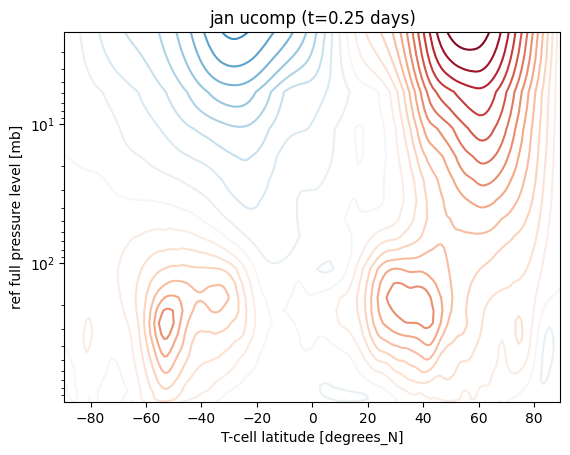

In [5]:
plot_init_u_xsection(am4_jan_ctl,name='jan')

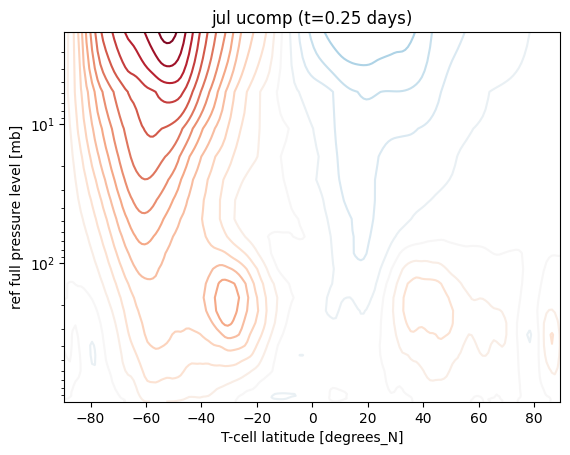

In [6]:
plot_init_u_xsection(am4_jul_ctl,name='jul')

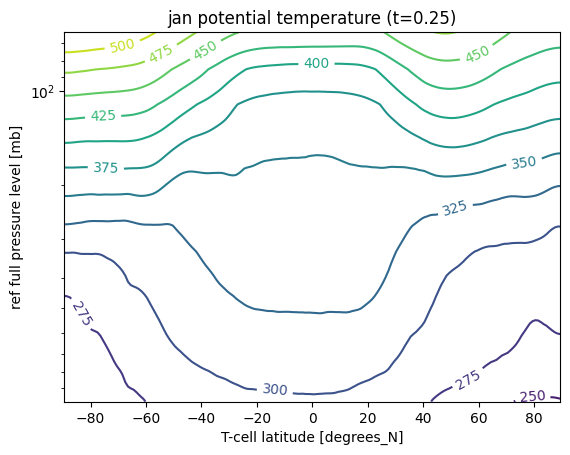

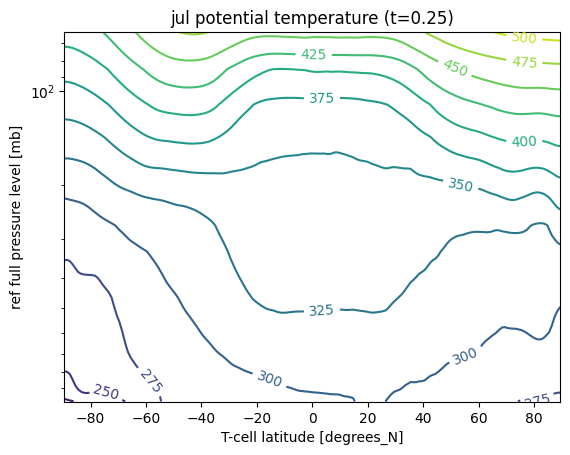

In [7]:
plot_potential_temperature(am4_jan_ctl,name='jan')
plt.figure()
plot_potential_temperature(am4_jul_ctl,name='jul')

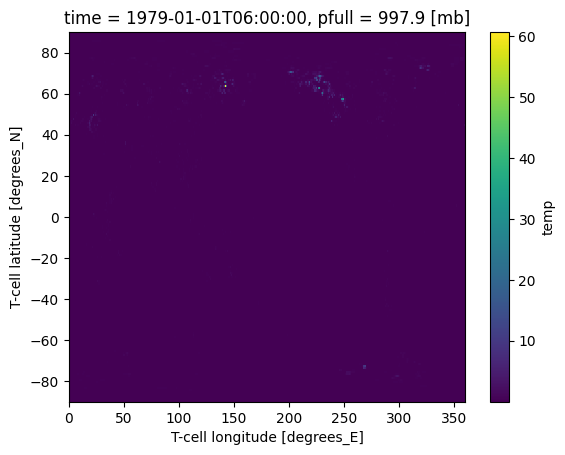

In [8]:
((am4_jan_ens.temp - am4_jan_ctl.temp)**2.0).isel(pfull=-1,time=0).mean(dim='members').plot()

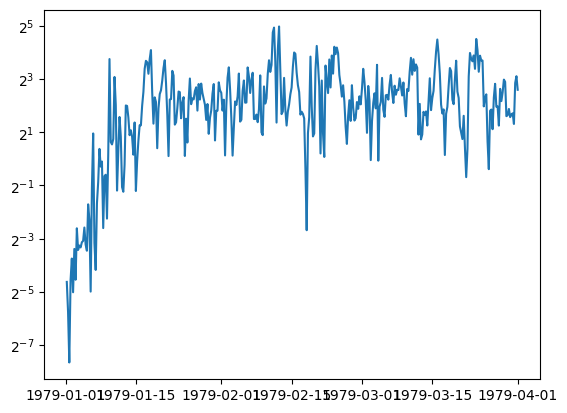

In [9]:
plot_error_growth_null_island(am4_jan_ens,am4_jan_ctl,var='ucomp',pfull='pfull')

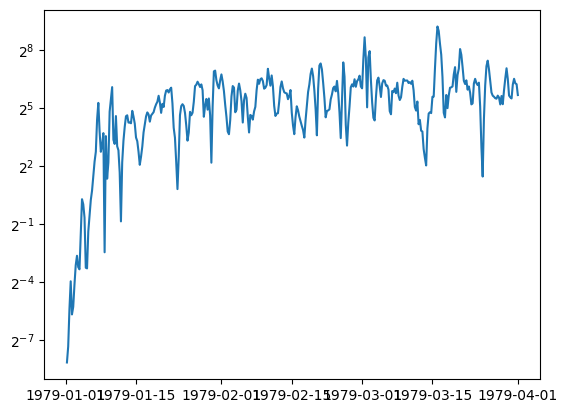

In [10]:
plot_error_growth_sh(am4_jan_ens,am4_jan_ctl,var='ucomp',pfull='pfull')

## MIMA

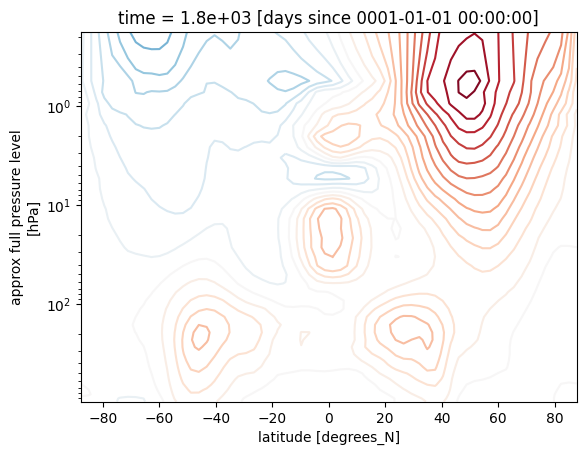

In [31]:
mima_ens, mima_ctl = load_mima()
plot_init_u_xsection(mima_ctl)

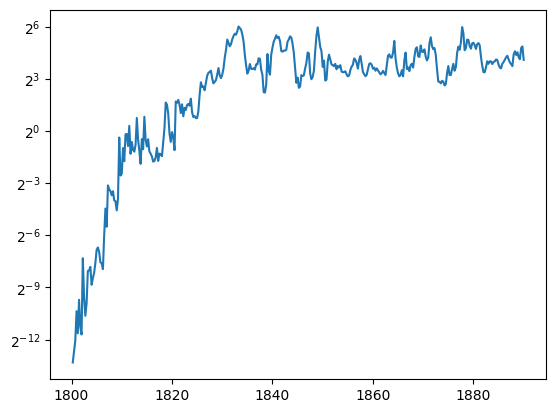

In [32]:
plot_error_growth_null_island(mima_ens,mima_ctl,var='ucomp',pfull='pfull')

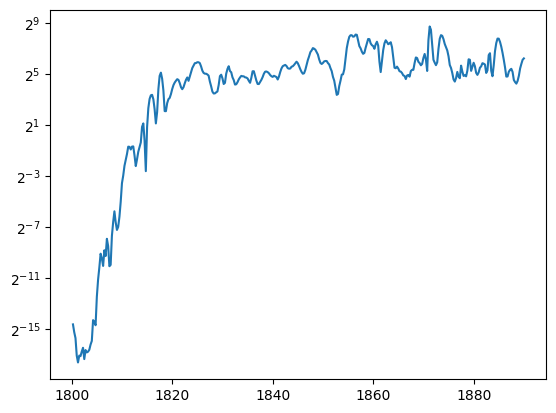

In [33]:
plot_error_growth_sh(mima_ens,mima_ctl,var='ucomp',pfull='pfull')

# ICON

In [6]:
_, icon_ctl= load_icon()
# _ = icon_ens.assign_coords(plev=icon_ens.plev/100)
icon_ctl = icon_ctl.assign_coords(plev=icon_ctl.plev/100)

### ICON CLIMATOLOGY

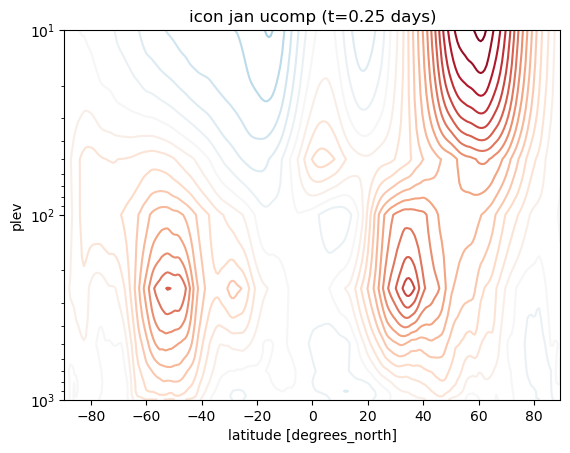

In [7]:
plot_init_u_xsection(icon_ctl,ucomp='u',pfull='plev',name='icon jan')

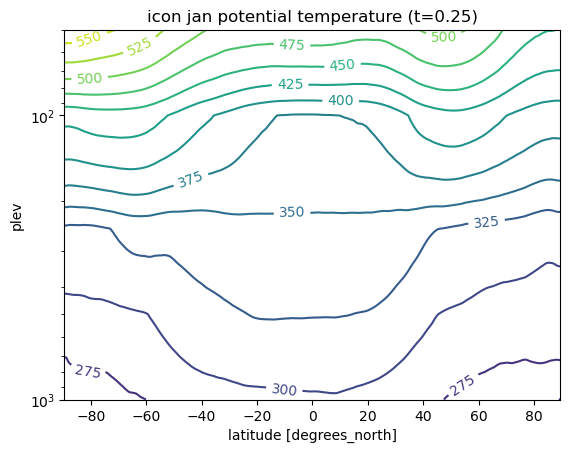

In [8]:
plot_potential_temperature(icon_ctl,pfull='plev',name='icon jan')

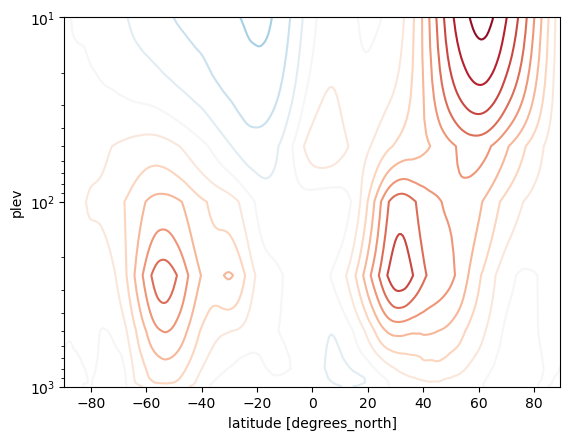

In [12]:
icon_ctl.u.mean(['time','lon']).plot.contour(levels=20,x='lat',y='plev',yincrease=False,yscale='log')

### ICON ENSEMBLE

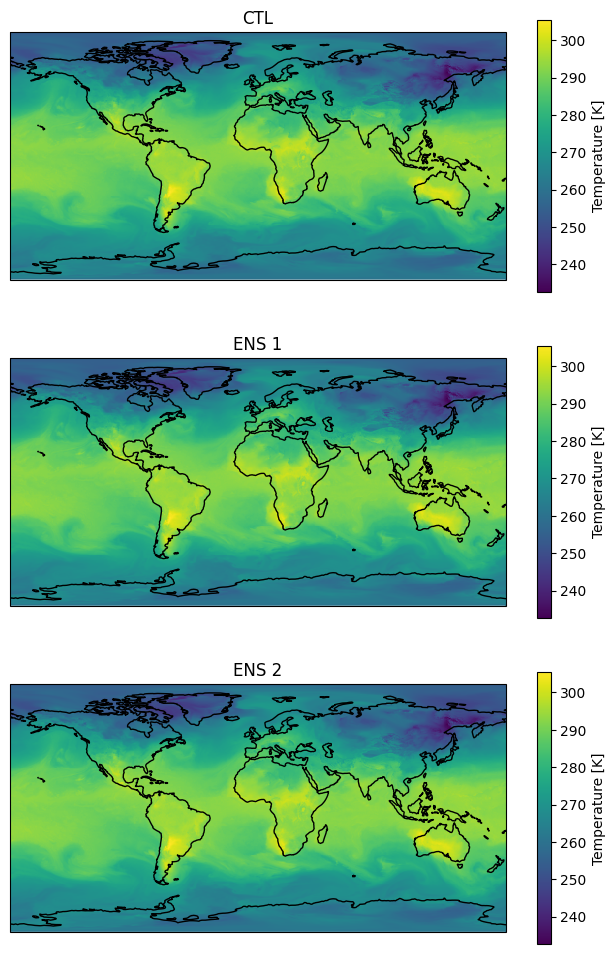

In [14]:
from matplotlib.animation import FuncAnimation
fig, (axctl,ax1,ax2) = plt.subplots(3,1,figsize=(8,12),subplot_kw={"projection":ccrs.PlateCarree()})
srfc_temp_ctl = icon_ctl.temp.sel(plev=900)
srfc_temp_ens = icon_ens.temp.sel(plev=900)

ctlmesh = srfc_temp_ctl.isel(time=0).plot.pcolormesh(ax=axctl,x='lon',y='lat',transform=ccrs.PlateCarree())

ens1mesh = srfc_temp_ens.isel(time=0,members=0).plot.pcolormesh(ax=ax1,x='lon',y='lat',transform=ccrs.PlateCarree())

ens2mesh = srfc_temp_ens.isel(time=0,members=1).plot.pcolormesh(ax=ax2,x='lon',y='lat',transform=ccrs.PlateCarree())
axctl.coastlines()
ax1.coastlines()
ax2.coastlines()
axctl.set_title("CTL")
ax1.set_title("ENS 1")
ax2.set_title("ENS 2")

def step(i):
    ctlmesh.set_array(srfc_temp_ctl.isel(time=i).values.flatten())
    ens1mesh.set_array(srfc_temp_ens.isel(time=i, members=0).values.flatten())
    ens2mesh.set_array(srfc_temp_ens.isel(time=i, members=1).values.flatten())
    return ctlmesh,ens1mesh,ens2mesh

anim = FuncAnimation(fig,step,interval=250,frames=len(icon_ctl.time))

ICON initial error

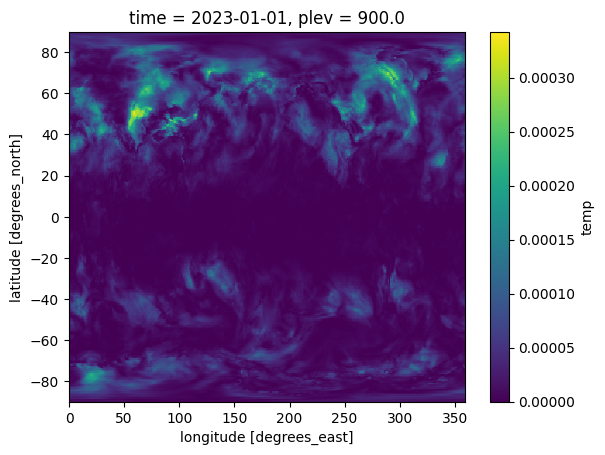

In [15]:
((srfc_temp_ens -srfc_temp_ctl)**2).mean(dim='members').isel(time=0).plot()

#### Icon error growth demo

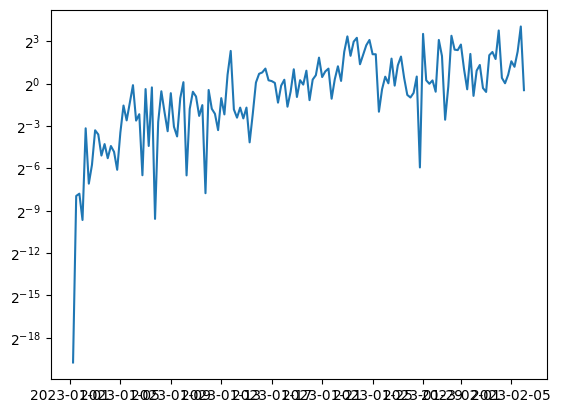

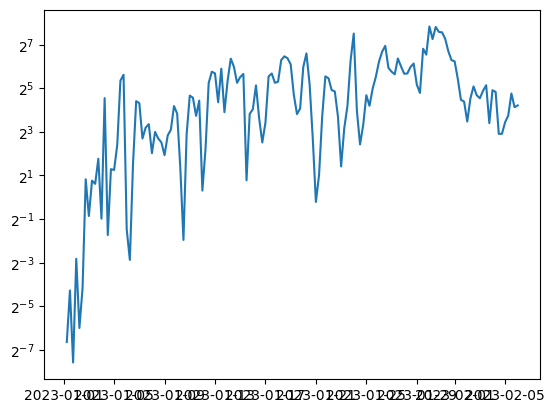

In [16]:
icon_ens_startsub = icon_ens.isel(time=slice(1,None))
icon_ctl_startsub = icon_ctl.isel(time=slice(1,None))
plot_error_growth_null_island(icon_ens_startsub,icon_ctl_startsub,var='u',pfull='plev')
plot_error_growth_sh(icon_ens_startsub,icon_ctl_startsub,var='u',pfull='plev')

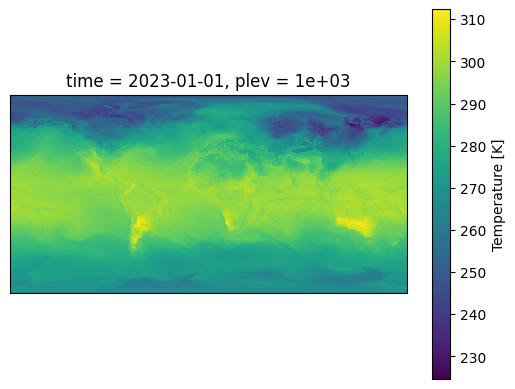

In [26]:
srfc_temp_ctl.isel(time=0).plot.pcolormesh(x='lon',y='lat',transform=ccrs.PlateCarree(),subplot_kws={'projection':ccrs.PlateCarree()})

In [27]:
ICON_OAK = '/oak/stanford/groups/aditis2/robcking/icon_coarse/base/N128/coarse_N128_atm_3d_6h_PL_20230126T000000Z.nc'
ds = xr.open_dataset(ICON_OAK)

In [28]:
ds.u.isel

<xarray.Dataset> Size: 69MB
Dimensions:  (time: 4, lon: 512, lat: 256, plev: 11)
Coordinates:
  * time     (time) datetime64[ns] 32B 2023-01-26 ... 2023-01-26T18:00:00
  * lon      (lon) float64 4kB 0.0 0.7031 1.406 2.109 ... 357.9 358.6 359.3
  * lat      (lat) float64 2kB 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
  * plev     (plev) float64 88B 1e+03 5e+03 1e+04 ... 9.5e+04 9.75e+04 1e+05
Data variables:
    u        (time, plev, lat, lon) float32 23MB ...
    v        (time, plev, lat, lon) float32 23MB ...
    temp     (time, plev, lat, lon) float32 23MB ...
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    source:       git@gitlab.dkrz.de:icon/icon-nwp.git@19fdc9a13604990f224d94...
    institution:  Max Planck Institute for Meteorology/Deutscher Wetterdienst
    title:        ICON simulation
    history:      Tue Aug 27 02:04:17 2024: cdo -remap,N128,/work/bm1233/b381...
    references:   see MPIM/DWD publications
    comment:      Claudia Stephan (m300685) on l40359 (Linux 4.18.0-477.58.1....
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...